In [94]:
import numpy as np
import pandas as pd
import time
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
import seaborn as sns

from sklearn.metrics import confusion_matrix, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset, random_split

In [95]:
def normalizeInputs(x_temp, input_minimum, input_maximum):
    """Normalize a datum that is an input to the neural network

    Parameters
    ----------
    x_temp: `numpy.array`
       image data
    input_minimum: `float`
       minimum value for normalization
    input_maximum: `float`
       maximum value for normalization

    Returns
    -------
    x_temp_norm: `numpy.array`
       normalized image data
    """
    x_temp_norm = (x_temp - input_minimum)/input_maximum
    return x_temp_norm

In [96]:
def createFileUidTimestamp():
    """Create a timestamp for a filename.

    Parameters
    ----------
    None

    Returns
    -------
    file_uid_timestamp : `string`
       String from date and time.
    """
    file_uid_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    return file_uid_timestamp

In [97]:
def createFileName(file_prefix="", file_location="Data/Sandbox/",
                   file_suffix="", useuid=True, verbose=True):
    """Create a file name.

    Parameters
    ----------
    file_prefix: `string`
       prefix of file name
    file_location: `string`
       path to file
    file_suffix: `string`
       suffix/extension of file name
    useuid: 'bool'
       choose to use a unique id
    verbose: 'bool'
       choose to print the file name

    Returns
    -------
    file_final: `string`
        filename used for saving
    """
    if useuid:
        file_uid = createFileUidTimestamp()
    else:
        file_uid = ""

    file_final = file_location + file_prefix + "_" + file_uid + file_suffix

    if verbose:
        print(file_final)

    return file_final

In [98]:
def plotArrayImageExamples(subset_train,
                           num_row=3, num_col=3,
                           object_index_start=0,
                           figsize=(7, 7),
                           save_file=False,
                           file_prefix="ImageExamples",
                           file_location="./",
                           file_suffix=".png"):
    """Plot an array of examples of images and labels

    Parameters
    ----------
    subset_train: `numpy.ndarray`
       training data images
    num_row: `int`, optional
       number of rows to plot
    num_col: `int`, optional
       number of columns to plot
    figsize: `tuple`, optional
       size of figure
    object_index_start: `int`, optional
       starting index for set of images to plot
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    From: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

    Returns
    -------
    None
    """
    labels_map = {
        0: "0",
        1: "1",
        2: "2",
        3: "3",
        4: "4",
        5: "5",
        6: "6",
        7: "7",
        8: "8",
        9: "9",
    }

    figure = plt.figure(figsize=figsize)

    for i in range(0, num_row * num_col):
        sample_idx = object_index_start + i
        img, label = subset_train[sample_idx]
        figure.add_subplot(num_row, num_col, i + 1)
        plt.title("label (digit): " + labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")

    plt.tight_layout()

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)
        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [99]:
def plotArrayHistogramExamples(subset_train,
                               num_row=3, num_col=3,
                               n_bins=10,
                               object_index_start=0,
                               figsize=(7, 7),
                               save_file=False,
                               file_prefix="HistogramExamples",
                               file_location="./",
                               file_suffix=".png"):
    """Plot histograms of image pixel values

    Parameters
    ----------
    subset_train: `numpy.ndarray`
       training data images
    num_row: `int`, optional
       number of rows to plot
    num_col: `int`, optional
       number of columns to plot
    n_bins: `int`, optional
       number of bins in histogram 
    object_index_start: `int`, optional
       starting index for set of images to plot
    figsize: `tuple`, optional
       size of figure
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    labels_map = {
        0: "0",
        1: "1",
        2: "2",
        3: "3",
        4: "4",
        5: "5",
        6: "6",
        7: "7",
        8: "8",
        9: "9",
    }

    fig, axes = plt.subplots(num_row, num_col,
                             figsize=figsize)

    for i in range(0, num_row * num_col):
        sample_idx = object_index_start + i
        img, label = subset_train[sample_idx]
        ax = axes[i//num_col, i%num_col]
        img_temp = img[0, :, :]
        img_temp = np.array(img_temp).flat
        ax.hist(img_temp, bins=n_bins, color='gray')
        ax.set_title("label (digit): " + labels_map[label])
        ax.set_xlabel("Pixel Values")

    plt.tight_layout()

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)
        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [100]:
def predict(dataloader, model, dataset_type):
    """Predict labels of inputs

    Parameters
    ----------
    dataloader: `numpy.ndarray`
       training data images
    model: `int`, optional
       number of rows to plot
    dataset_type: `int`, optional
       number of columns to plot

    Returns
    -------
    y_prob_list: `numpy.ndarray`
       probabilities for each class for each input
    y_choice_list: `numpy.ndarray`
       highest-probability class for each input
    y_true_list: `numpy.ndarray`
       true class for each input
    x_list: `numpy.ndarray`
       input
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    y_prob_list = []
    y_choice_list = []
    y_true_list = []
    x_list = []

    i = 0
    loss, accuracy = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            y = model(inputs)
            y_prob = torch.softmax(y, dim=1)
            y_choice = (torch.max(torch.exp(y), 1)[1]).data.cpu().numpy()

            loss += loss_fn(y, labels).item()
            loss /= num_batches
            accuracy_temp = y.argmax(1) == labels
            accuracy += accuracy_temp.type(torch.float).sum().item()
            accuracy /= size

            y_prob_list.append(y_prob.detach())
            y_choice_list.append(y_choice)
            y_true_list.append(labels)
            x_list.append(inputs)
            labels = labels.data.cpu().numpy()

            i += 1

        y_prob_list = np.array(y_prob_list)
        y_choice_list = np.array(y_choice_list)
        y_true_list = np.array(y_true_list)
        x_list = np.array(x_list)

        y_prob_list = np.squeeze(y_prob_list)
        y_choice_list = np.squeeze(y_choice_list)
        y_true_list = np.squeeze(y_true_list)
        x_list = np.squeeze(x_list)

        print(f"{dataset_type : <10} data set ...\
             Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {loss:>8f}")

    return y_prob_list, y_choice_list, y_true_list, x_list

In [101]:
def predict(dataloader, model, dataset_type):
    model.eval()
    all_probs   = []
    all_choices = []
    all_trues   = []
    all_inputs  = []

    total_loss = 0.0
    total_correct = 0
    total_samples = len(dataloader.dataset)
    num_batches = len(dataloader)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs   = torch.softmax(outputs, dim=1)

            # ---- CORRECCIÓN ACÁ ----
            # Mover a CPU y convertir a numpy ANTES de guardar
            all_probs.append(  probs.cpu().numpy() )
            all_choices.append(probs.argmax(dim=1).cpu().numpy())
            all_trues.append(  labels.cpu().numpy())
            all_inputs.append( inputs.cpu().numpy())

            # Cálculo de pérdida y accuracy
            total_loss += loss_fn(outputs, labels).item()
            total_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Promedios finales
        avg_loss = total_loss / num_batches
        accuracy = total_correct / total_samples * 100.0

    # Concatenar todo en arrays únicos
    y_prob_list   = np.concatenate(all_probs,   axis=0)
    y_choice_list = np.concatenate(all_choices, axis=0)
    y_true_list   = np.concatenate(all_trues,   axis=0)
    x_list        = np.concatenate(all_inputs,  axis=0)

    print(f"{dataset_type:<10} data set ... Accuracy: {accuracy:>5.1f}%, Avg loss: {avg_loss:.6f}")

    return y_prob_list, y_choice_list, y_true_list, x_list



In [102]:
def plotPredictionHistogram(y_prediction_a, y_prediction_b=None,
                            y_prediction_c=None, n_classes=None,
                            n_objects_a=None, n_colors=None,
                            title_a=None, title_b=None,
                            title_c=None, label_a=None,
                            label_b=None, label_c=None,
                            alpha=1.0, figsize=(12, 5),
                            save_file=False,
                            file_prefix="prediction_histogram",
                            file_location="./",
                            xlabel_plot="Class label",
                            file_suffix=".png"):
    """Plot histogram of predicted labels

    Parameters
    ----------
    y_prediction_a: `numpy.ndarray`
    y_prediction_b: `numpy.ndarray`, optional
    y_prediction_c: `numpy.ndarray`, optional
    n_classes: `int`, optional
    n_objects_a: `int`, optional
    n_colors: `int`, optional
    title_a: `string`, optional
    title_b: `string`, optional
    title_c: `string`, optional
    label_a: `string`, optional
    label_b: `string`, optional
    label_c: `string`, optional
    alpha: `float`, optional
       transparency
    figsize: `tuple`, optional
       figure size
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    ndim = y_prediction_a.ndim

    if ndim == 2:
        fig, (axa, axb, axc) = plt.subplots(1, 3, figsize=figsize)
        fig.subplots_adjust(wspace=0.35)
    elif ndim == 1:
        fig, ax = plt.subplots(figsize=figsize)

    shape_a = np.shape(y_prediction_a)

    if n_objects_a is None:
        n_objects_a = shape_a[0]

    if ndim == 2:
        if n_classes is None:
            n_classes = shape_a[1]
        if n_colors is None:
            n_colors = n_classes
    elif ndim == 1:
        if n_colors is None:
            n_colors = 1

    if ndim == 2:
        colors = cm.Purples(np.linspace(0, 1, n_colors))
        xlabel = "Probability for Each Class"

        axa.set_ylim(0, n_objects_a)
        axa.set_xlabel(xlabel)
        axa.set_title(title_a)

        for i in np.arange(n_classes):
            axa.hist(y_prediction_a[:, i], alpha=alpha,
                     color=colors[i], label="'" + str(i) + "'")

        if y_prediction_b is not None:
            shape_b = np.shape(y_prediction_b)
            axb.set_ylim(0, shape_b[0])
            axb.set_xlabel(xlabel)
            axb.set_title(title_b)

            for i in np.arange(n_classes):
                axb.hist(y_prediction_b[:, i], alpha=alpha,
                         color=colors[i], label="'" + str(i) + "'")

        if y_prediction_c is not None:
            shape_c = np.shape(y_prediction_c)
            axc.set_ylim(0, shape_c[0])
            axc.set_xlabel(xlabel)
            axc.set_title(title_c)

            for i in np.arange(n_classes):
                axc.hist(y_prediction_c[:, i], alpha=alpha,
                         color=colors[i], label="'" + str(i) + "'")

    elif ndim == 1:
        ya, xa, _ = plt.hist(y_prediction_a, alpha=alpha, color='orange',
                             label=label_a)
        y_max_list = [max(ya)]

        if y_prediction_b is not None:
            yb, xb, _ = plt.hist(y_prediction_b, alpha=alpha, color='green',
                                 label=label_b)
            y_max_list.append(max(yb))

        if y_prediction_c is not None:
            yc, xc, _ = plt.hist(y_prediction_c, alpha=alpha, color='purple',
                                 label=label_c)
            y_max_list.append(max(yc))

        plt.ylim(0, np.max(y_max_list)*1.1)
        plt.xlabel(xlabel_plot)

    plt.legend(loc='upper right')

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)
        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [103]:
def plotTrueLabelHistogram(y_prediction_a, y_prediction_b=None,
                           y_prediction_c=None, n_classes=None,
                           n_objects_a=None, n_colors=None,
                           title_a=None, title_b=None,
                           title_c=None, label_a=None,
                           label_b=None, label_c=None,
                           alpha=1.0, figsize=(12, 5),
                           save_file=False,
                           file_prefix="prediction_histogram",
                           file_location="./",
                           xlabel_plot="Class label",
                           file_suffix=".png"):
    """Plot histogram of predicted labels

    Parameters
    ----------
    y_prediction_a: `numpy.ndarray`
    y_prediction_b: `numpy.ndarray`, optional
    y_prediction_c: `numpy.ndarray`, optional
    n_classes: `int`, optional
    n_objects_a: `int`, optional
    n_colors: `int`, optional
    title_a: `string`, optional
    title_b: `string`, optional
    title_c: `string`, optional
    label_a: `string`, optional
    label_b: `string`, optional
    label_c: `string`, optional
    alpha: `float`, optional
       transparency
    figsize: `tuple`, optional
       figure size
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """

    ndim = y_prediction_a.ndim

    if ndim == 2:
        fig, (axa, axb, axc) = plt.subplots(1, 3, figsize=figsize)
        fig.subplots_adjust(wspace=0.35)
    elif ndim == 1:
        fig, ax = plt.subplots(figsize=figsize)

    shape_a = np.shape(y_prediction_a)

    if n_objects_a is None:
        n_objects_a = shape_a[0]

    if ndim == 2:
        if n_classes is None:
            n_classes = shape_a[1]
        if n_colors is None:
            n_colors = n_classes
    elif ndim == 1:
        if n_colors is None:
            n_colors = 1

    if ndim == 2:
        colors = cm.Purples(np.linspace(0, 1, n_colors))
        xlabel = "Probability for Each Class"

        axa.set_ylim(0, n_objects_a)
        axa.set_xlabel(xlabel)
        axa.set_title(title_a)

        for i in np.arange(n_classes):
            axa.hist(y_prediction_a[:, i], alpha=alpha,
                     color=colors[i], label="'" + str(i) + "'")

        if y_prediction_b is not None:
            shape_b = np.shape(y_prediction_b)
            axb.set_ylim(0, shape_b[0])
            axb.set_xlabel(xlabel)
            axb.set_title(title_b)

            for i in np.arange(n_classes):
                axb.hist(y_prediction_b[:, i], alpha=alpha,
                         color=colors[i], label="'" + str(i) + "'")

        if y_prediction_c is not None:
            shape_c = np.shape(y_prediction_c)
            axc.set_ylim(0, shape_c[0])
            axc.set_xlabel(xlabel)
            axc.set_title(title_c)

            for i in np.arange(n_classes):
                axc.hist(y_prediction_c[:, i], alpha=alpha,
                         color=colors[i], label="'" + str(i) + "'")

    elif ndim == 1:
        ya, xa, _ = plt.hist(y_prediction_a, alpha=alpha, color='orange',
                             label=label_a)
        y_max_list = [max(ya)]

        if y_prediction_b is not None:
            yb, xb, _ = plt.hist(y_prediction_b, alpha=alpha, color='green',
                                 label=label_b)
            y_max_list.append(max(yb))

        if y_prediction_c is not None:
            yc, xc, _ = plt.hist(y_prediction_c, alpha=alpha, color='purple',
                                 label=label_c)
            y_max_list.append(max(yc))

        plt.ylim(0, np.max(y_max_list)*1.1)
        plt.xlabel(xlabel_plot)

    plt.legend(loc='upper right')

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)
        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [104]:
def plotLossHistory(history, figsize=(8, 5),
                    save_file=False,
                    file_prefix="prediction_histogram",
                    file_location="./",
                    file_suffix=".png"):
    """Plot loss history of the model as function of epoch

    Parameters
    ----------
    history: `keras.src.callbacks.history.History`
       keras callback history object containing the losses at each epoch
    figsize: `tuple`, optional
       figure size
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize)

    loss_tra = np.array(history['loss'])
    loss_val = np.array(history['val_loss'])
    loss_dif = loss_val - loss_tra

    ax1.plot(loss_tra, label='Training')
    ax1.plot(loss_val, label='Validation')
    ax1.legend()

    ax2.plot(loss_dif, color='red', label='residual')
    ax2.axhline(y=0, color='grey', linestyle='dashed', label='zero bias')
    ax2.sharex(ax1)
    ax2.legend()

    ax1.set_title('Loss History')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Loss Residual')
    ax2.set_xlabel('Epoch')
    plt.tight_layout()

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)

        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [105]:
def plotArrayImageConfusion(x_tra, y_tra, y_pred_tra_topchoice,
                            title_main=None, num=10,
                            save_file=False,
                            file_prefix="prediction_histogram",
                            file_location="./",
                            file_suffix=".png"):
    """Plot images of examples objects that are misclassified.

    Parameters
    ----------
    x_tra: `numpy.ndarray`
       training image data
    y_tra: `numpy.ndarray`
       training label data
    y_pred_tra_topchoice: `numpy.ndarray`
       top choice of the predicted labels
    title_main: `string`, optional
       title for the plot
    num: `int`, optional
       number of examples
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    num_row = 2
    num_col = 5
    images = x_tra[:num]
    labels_true = y_tra[:num]
    labels_pred = y_pred_tra_topchoice[:num]

    fig, axes = plt.subplots(num_row, num_col,
                             figsize=(1.5*num_col, 2*num_row))

    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('cornflowerblue')

    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title(r'True: {}'.format(labels_true[i]) + '\n'
                     + 'Pred: {}'.format(labels_pred[i]))

    fig.suptitle(title_main)
    plt.tight_layout()

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)

        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [106]:
def plotROCMulticlassOnevsrest(y_tra, y_tes, y_pred_tes,
                               figsize=(7, 7),
                               save_file=False,
                               file_prefix="ImageExamples",
                               file_location="./",
                               file_suffix=".png"):
    """Plot the one-vs-rest ROC curve

    Parameters
    ----------
    y_tra: `numpy.ndarray`
       training data true labels
    y_tes: `numpy.ndarray`
       testing data true labels
    y_pred_tes: `numpy.ndarray`
       testing data predicted labels
    figsize: `tuple`, optional
       size of figure
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=figsize)
    n_classes = len(y_prob_tes[0])
    label_target_list = np.linspace(0, n_classes-1, num=n_classes)
    color_list = cm.rainbow(np.linspace(0, 0.5, n_classes))

    for label_target, color in zip(label_target_list, color_list):        
        label_binarizer = LabelBinarizer().fit(y_tra)
        y_onehot_tes = label_binarizer.transform(y_tes)
        class_id = np.flatnonzero(label_binarizer.classes_ == label_target)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_tes[:, class_id],
            y_pred_tes[:, class_id],
            name=f"{int(label_target)} vs the rest",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 9)
        )
        
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="ROC: One-vs-Rest",
    )

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)
        plt.savefig(file_final, bbox_inches='tight')

In [107]:
def plotArrayHistogramConfusion(x_tra, y_tra, y_pred_tra_topchoice,
                                title_main=None, num=10,
                                save_file=False,
                                file_prefix="prediction_histogram",
                                file_location="./",
                                file_suffix=".png"):
    """Plot histograms of pixel values for images that are misclassified.

    Parameters
    ----------
    x_tra: `numpy.ndarray`
       training image data
    y_tra: `numpy.ndarray`
       training label data
    y_pred_tra_topchoice: `numpy.ndarray`
       top choice of the predicted labels
    title_main: `string`, optional
       title of plot
    num: `int`, optional
       number of examples
    file_prefix: `string`, optional
       prefix of file name
    file_location: `string`, optional
       path to file
    file_suffix: `string`, optional
       suffix/extension of file name

    Returns
    -------
    None
    """
    n_bins = 10
    num_row = 2
    num_col = 5
    images = x_tra[:num]
    labels_true = y_tra[:num]
    labels_pred = y_pred_tra_topchoice[:num]

    fig, axes = plt.subplots(num_row, num_col,
                             figsize=(1.5*num_col, 2*num_row))

    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('cornflowerblue')

    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        images_temp = images[i, :, :].flat
        ax.hist(images_temp, bins=n_bins, color='gray')
        ax.set_title(r'True: {}'.format(labels_true[i]) + '\n'
                     + 'Pred: {}'.format(labels_pred[i]))
        ax.set_xlabel('Pixel Values')

    fig.suptitle(title_main)
    plt.tight_layout()

    if save_file:
        file_final = createFileName(file_prefix=file_prefix,
                                    file_location=file_location,
                                    file_suffix=file_suffix,
                                    useuid=True)

        plt.savefig(file_final, bbox_inches='tight')

    plt.show()

In [108]:
run_label = "Run000"

path_temp = os.getenv("HOME") + '/dp02_19a_temp'
path_dict = {'run_label': run_label,
             'dir_data_model': path_temp + "/Models/",
             'dir_data_figures': path_temp + "/Figures/",
             'dir_data_data': path_temp + "/Data/",
             'file_model_prefix': "Model",
             'file_figure_prefix': "Figure",
             'file_figure_suffix': ".png",
             'file_model_suffix': ".pt"
             }
del path_temp

if not os.path.exists(path_dict['dir_data_model']):
    os.makedirs(path_dict['dir_data_model'])

if not os.path.exists(path_dict['dir_data_figures']):
    os.makedirs(path_dict['dir_data_figures'])

if not os.path.exists(path_dict['dir_data_data']):
    os.makedirs(path_dict['dir_data_data'])

In [109]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [110]:
%%time
dataset = torchvision.datasets.MNIST(root=path_dict['dir_data_data'], train=True,
                                     download=True, transform=transform)

CPU times: user 9.88 ms, sys: 43.9 ms, total: 53.8 ms
Wall time: 48.3 ms


In [111]:
fraction_tra = 0.8
fraction_val = 0.1
fraction_tes = 0.1

In [112]:
fraction_list = [fraction_tra, fraction_val, fraction_tes]

data_tra_full, data_val_full, data_tes_full = \
    torch.utils.data.random_split(dataset, fraction_list)

In [113]:
print("training:", len(data_tra_full.indices))
print("validation:", len(data_val_full.indices))
print("test", len(data_tes_full.indices))

training: 48000
validation: 6000
test 6000


In [114]:
subset_size = 5000

subset_indices_tra = np.arange(subset_size)
subset_indices_val = np.arange(subset_size)
subset_indices_tes = np.arange(subset_size)

data_tra = Subset(data_tra_full, subset_indices_tra)
data_val = Subset(data_val_full, subset_indices_val)
data_tes = Subset(data_tes_full, subset_indices_tes)

In [115]:
sample_index = 0
image, label = data_tra[sample_index]
print(f"The image shape is {image.shape}.")
print(f"The label for this image is {label}.")

The image shape is torch.Size([1, 28, 28]).
The label for this image is 0.


In [116]:
{v: k for k, v in dataset.class_to_idx.items()}

{0: '0 - zero',
 1: '1 - one',
 2: '2 - two',
 3: '3 - three',
 4: '4 - four',
 5: '5 - five',
 6: '6 - six',
 7: '7 - seven',
 8: '8 - eight',
 9: '9 - nine'}

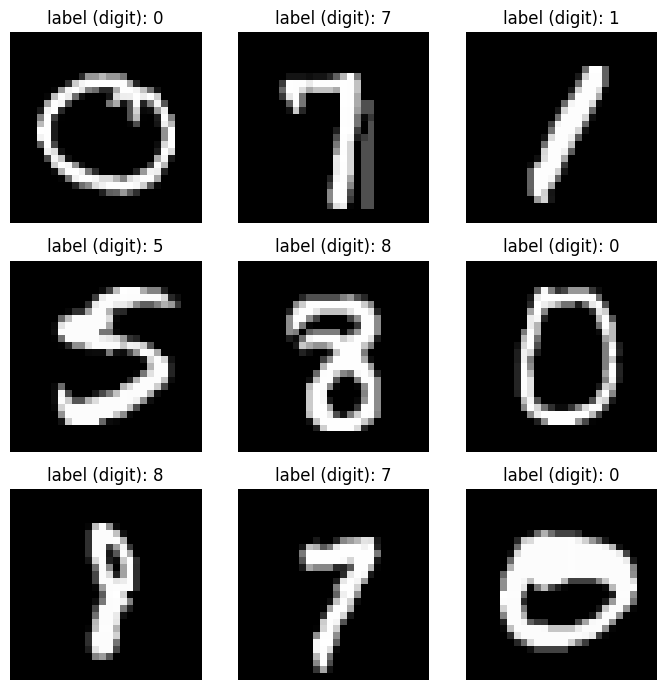

In [117]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
                                              + "Example_Image_Array"\
                                              + "_" + path_dict['run_label']

plotArrayImageExamples(data_tra,
                       num_row=3, num_col=3,
                       save_file=False,
                       object_index_start=0,
                       file_prefix=file_prefix,
                       file_location=path_dict['dir_data_figures'],
                       file_suffix=path_dict['file_figure_suffix'])

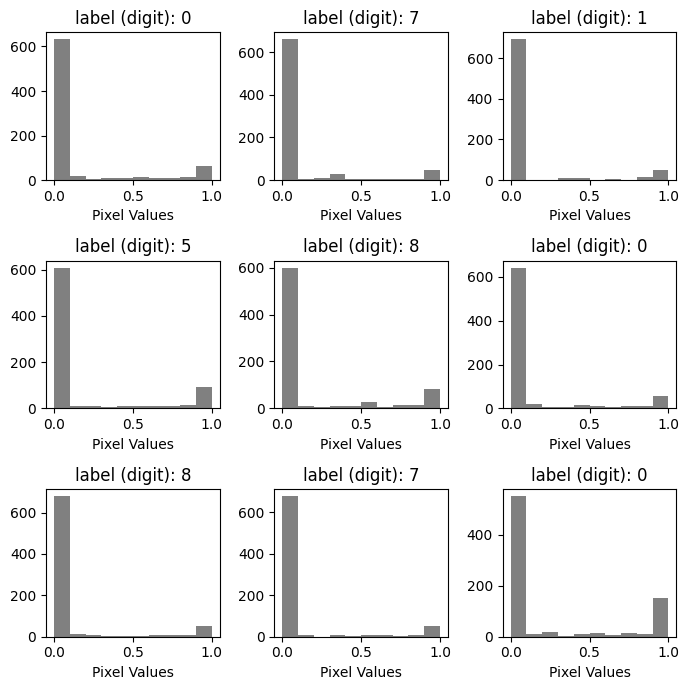

In [118]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
                                              + "Example_Histogram_Array"\
                                              + "_" + path_dict['run_label']

plotArrayHistogramExamples(data_tra,
                           num_row=3, num_col=3,
                           save_file=False,
                           file_prefix=file_prefix,
                           file_location=path_dict['dir_data_figures'],
                           file_suffix=path_dict['file_figure_suffix'])

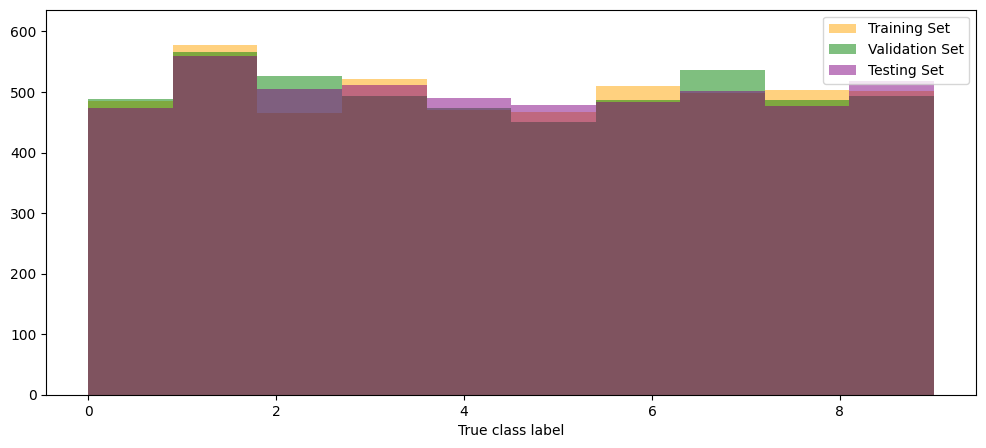

In [119]:
y_tra = []
y_val = []
y_tes = []

for i in np.arange(subset_size):
    image, label_tra = data_tra[i]
    image, label_val = data_val[i]
    image, label_tes = data_tes[i]
    y_tra.append(label_tra)
    y_val.append(label_val)
    y_tes.append(label_tes)

y_tra = np.array(y_tra)
y_val = np.array(y_val)
y_tes = np.array(y_tes)

file_prefix = path_dict['file_figure_prefix'] + "_"\
                                              + "Histograms_true_class"\
                                              + "_" + path_dict['run_label']

plotPredictionHistogram(y_tra,
                        y_prediction_b=y_val,
                        y_prediction_c=y_tes,
                        label_a="Training Set",
                        label_b="Validation Set",
                        label_c="Testing Set",
                        figsize=(12, 5),
                        alpha=0.5,
                        xlabel_plot="True class label",
                        file_prefix=file_prefix,
                        file_location=path_dict['dir_data_figures'],
                        file_suffix=path_dict['file_figure_suffix'])

In [120]:
batch_size = subset_size

In [121]:
trainloader = torch.utils.data.DataLoader(data_tra, batch_size=batch_size,
                                          shuffle=False)

validloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size,
                                          shuffle=False)

testloader = torch.utils.data.DataLoader(data_tes, batch_size=batch_size,
                                         shuffle=False)

In [122]:
seed = 1729
new = torch.manual_seed(seed)

In [123]:
loss_fn = nn.CrossEntropyLoss()

In [124]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = x
        return output

In [125]:
model = ConvNet()

In [126]:
device = torch.device('cuda') if torch.cuda.is_available()\
    else torch.device('cpu')

In [127]:
print("Model Summary:\n")
model.to(device)

Model Summary:



ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [128]:
learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
n_epochs = 50

In [129]:
%%capture
model.train()

In [130]:
%%time
time_start = time.time()

loss_train_list = []
loss_test_list = []
accuracy_test_list = []

for epoch in np.arange(n_epochs):

    loss_train = 0
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

    loss_train /= batch_size

    accuracy_test = 0
    loss_test = 0
    count_test = 0
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        accuracy_test += (torch.argmax(y_pred, 1) == labels).float().sum()
        loss_test += loss.item()
        count_test += len(labels)

    accuracy_test /= count_test
    loss_test /= batch_size

    loss_train_list.append(loss_train)
    loss_test_list.append(loss_test)
    accuracy_test_list.append(accuracy_test)

    # output = f"Epoch ({epoch:3d}):   accuracy ({accuracy_test*100:.2f} %),\
    output1 = f"Epoch ({epoch:2d}):   accuracy ({accuracy_test*50:.2f} %),  "
    output2 = f"train loss ({loss_train:.4f}),  valid loss ({loss_test:.4f})"
    output = output1 + output2
    print(output)

time_end = time.time()

time_difference = time_end - time_start

history = {"loss": loss_train_list,
           "val_loss": loss_test_list,
           "accuracy_test": accuracy_test_list}

print(f"Total training time: {time_difference/60.:2.4f} min")

Epoch ( 0):   accuracy (5.28 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 1):   accuracy (5.31 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 2):   accuracy (5.67 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 3):   accuracy (5.76 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 4):   accuracy (6.56 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 5):   accuracy (7.50 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 6):   accuracy (8.41 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 7):   accuracy (9.91 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 8):   accuracy (10.32 %),  train loss (0.0005),  valid loss (0.0005)
Epoch ( 9):   accuracy (10.98 %),  train loss (0.0005),  valid loss (0.0005)
Epoch (10):   accuracy (11.53 %),  train loss (0.0005),  valid loss (0.0005)
Epoch (11):   accuracy (12.00 %),  train loss (0.0005),  valid loss (0.0005)
Epoch (12):   accuracy (12.81 %),  train loss (0.0005),  valid loss (0.0005)
Epoch (

In [131]:
file_prefix = path_dict['file_model_prefix'] + "_" + path_dict['run_label']
file_name_final = createFileName(file_prefix=file_prefix,
                                 file_location=path_dict['dir_data_model'],
                                 file_suffix=path_dict['file_model_suffix'],
                                 useuid=True,
                                 verbose=True)

torch.save(model.state_dict(), file_name_final)

/home/usuario/dp02_19a_temp/Models/Model_Run000_20250616_224129.pt


In [132]:
%%capture
model.load_state_dict(torch.load(file_name_final, weights_only=False))

In [133]:
%%capture
model.eval()

In [134]:
y_prob_tes, y_choice_tes, y_true_tes, x_tes = predict(testloader, model,
                                                      "test")
y_prob_val, y_choice_val, y_true_val, x_val = predict(validloader, model,
                                                      "validation")
y_prob_tra, y_choice_tra, y_true_tra, x_tra = predict(trainloader, model,
                                                      "training")

test       data set ... Accuracy:  85.7%, Avg loss: 0.488751
validation data set ... Accuracy:  85.4%, Avg loss: 0.498802
training   data set ... Accuracy:  86.2%, Avg loss: 0.491235


In [135]:
print(f"The input data has the shape {np.shape(x_tes)}: there the {subset_size}\
 images each image has 28 pixels on a side.")
print(f"The predicted probability score array has the shape\
 {np.shape(y_prob_tes)}: there are {subset_size} predictions,\
 with 10 probability scores predicted for each input image.")
print(f"The predicted classes array has has the shape {np.shape(y_choice_tes)}:\
 there is one top choice (highest probability score) for each prediction.")

The input data has the shape (5000, 1, 28, 28): there the 5000 images each image has 28 pixels on a side.
The predicted probability score array has the shape (5000, 10): there are 5000 predictions, with 10 probability scores predicted for each input image.
The predicted classes array has has the shape (5000,): there is one top choice (highest probability score) for each prediction.


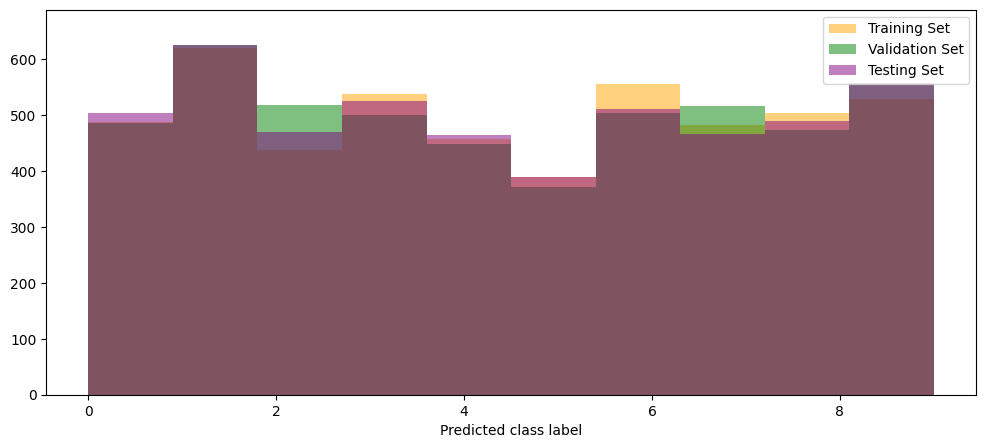

In [136]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
    + "Histograms_top_choice"\
    + "_" + path_dict['run_label']

plotPredictionHistogram(y_choice_tra,
                        y_prediction_b=y_choice_val,
                        y_prediction_c=y_choice_tes,
                        label_a="Training Set",
                        label_b="Validation Set",
                        label_c="Testing Set",
                        figsize=(12, 5),
                        alpha=0.5,
                        xlabel_plot="Predicted class label",
                        file_prefix=file_prefix,
                        file_location=path_dict['dir_data_figures'],
                        file_suffix=path_dict['file_figure_suffix'])

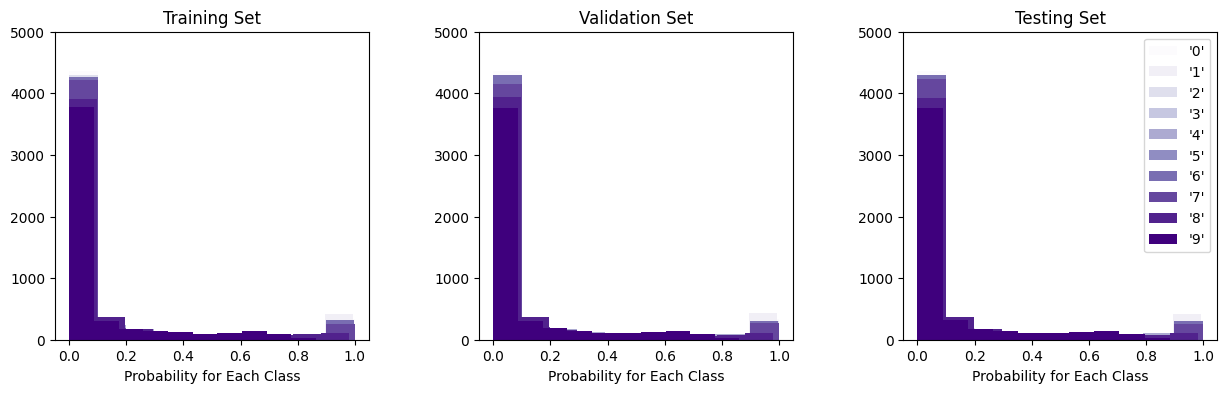

In [137]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
    + "Histograms_class_probabilities"\
    + "_" + path_dict['run_label']

plotPredictionHistogram(y_prob_tra,
                        y_prediction_b=y_prob_val,
                        y_prediction_c=y_prob_tes,
                        title_a='Training Set',
                        title_b='Validation Set',
                        title_c='Testing Set',
                        figsize=(15, 4),
                        file_prefix=file_prefix,
                        file_location=path_dict['dir_data_figures'],
                        file_suffix=path_dict['file_figure_suffix'])

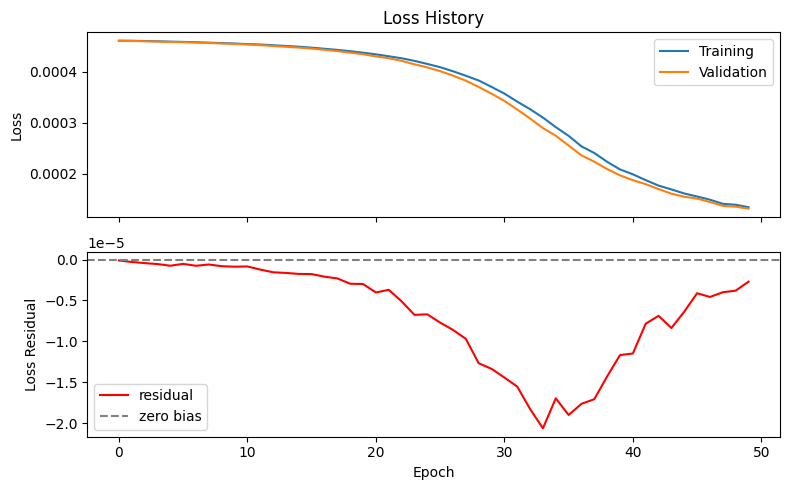

In [138]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
                                              + "LossHistory"\
                                              + "_"\
                                              + path_dict['run_label']

plotLossHistory(history,
                file_prefix=file_prefix,
                file_location=path_dict['dir_data_figures'],
                file_suffix=path_dict['file_figure_suffix'])

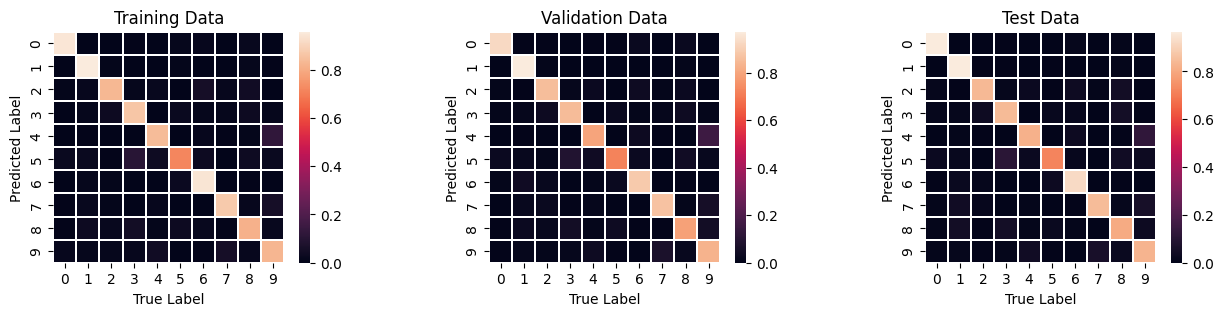

In [139]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
figsize = (15, 3)
linewidths = 0.01
linecolor = 'white'
ylabel = "Predicted Label"
xlabel = "True Label"

cm_tra = confusion_matrix(y_true_tra, y_choice_tra)
cm_val = confusion_matrix(y_true_val, y_choice_val)
cm_tes = confusion_matrix(y_true_tes, y_choice_tes)

df_cm_tra = pd.DataFrame(cm_tra / np.sum(cm_tra, axis=1)[:, None],
                         index=[i for i in classes],
                         columns=[i for i in classes])
df_cm_val = pd.DataFrame(cm_val / np.sum(cm_val, axis=1)[:, None],
                         index=[i for i in classes],
                         columns=[i for i in classes])
df_cm_tes = pd.DataFrame(cm_tes / np.sum(cm_tes, axis=1)[:, None],
                         index=[i for i in classes],
                         columns=[i for i in classes])

fig, (axa, axb, axc) = plt.subplots(1, 3, figsize=figsize)
fig.subplots_adjust(wspace=0.5)

ax1 = sns.heatmap(df_cm_tra, annot=False, linewidths=linewidths,
                  linecolor=linecolor, square=True, ax=axa)
_ = ax1.set(xlabel=xlabel, ylabel=ylabel, title="Training Data")

ax2 = sns.heatmap(df_cm_val, annot=False, linewidths=linewidths,
                  linecolor=linecolor, square=True, ax=axb)
_ = ax2.set(xlabel=xlabel, ylabel=ylabel, title="Validation Data")

ax3 = sns.heatmap(df_cm_tes, annot=False, linewidths=linewidths,
                  linecolor=linecolor, square=True, ax=axc)
_ = ax3.set(xlabel=xlabel, ylabel=ylabel, title="Test Data")

/home/usuario/PSF/venv1/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/usuario/PSF/venv1/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/usuario/PSF/venv1/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/usuario/PSF/venv1/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/home/usuario/PSF/venv1/lib/

/home/usuario/dp02_19a_temp/Figures/Figure_ROCCurve_Run000_20250616_224132.png


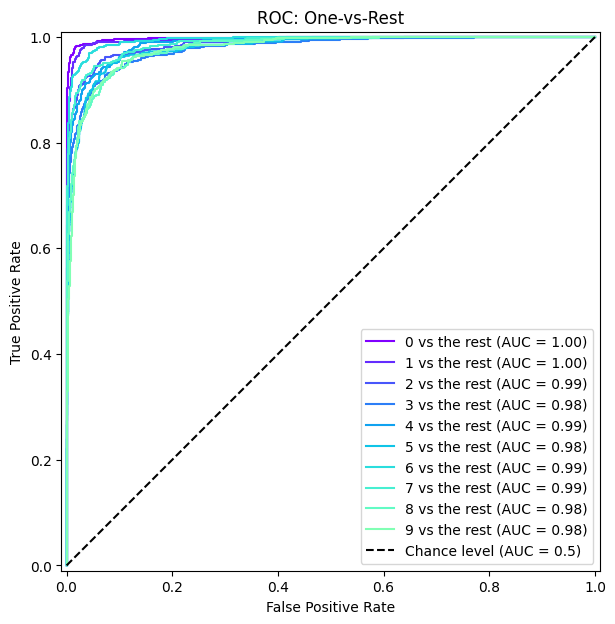

In [140]:
file_prefix = path_dict['file_figure_prefix'] + "_"\
                                              + "ROCCurve"\
                                              + "_"\
                                              + path_dict['run_label']

plotROCMulticlassOnevsrest(y_tra, y_tes, y_prob_tes,
                              save_file=True,
                              file_prefix=file_prefix,
                              file_location=path_dict['dir_data_figures'],
                              file_suffix=path_dict['file_figure_suffix'])

In [141]:
class_value = 2

In [142]:
ind_class_tp_tra = np.where((y_true_tra == class_value)
                            & (y_choice_tra == class_value))[0]

ind_class_fp_tra = np.where((y_true_tra != class_value)
                            & (y_choice_tra == class_value))[0]

ind_class_tn_tra = np.where((y_true_tra != class_value)
                            & (y_choice_tra != class_value))[0]

ind_class_fn_tra = np.where((y_true_tra == class_value)
                            & (y_choice_tra != class_value))[0]

x_tra_tp = x_tra[ind_class_tp_tra]
y_true_tra_tp = y_true_tra[ind_class_tp_tra]
y_choice_tra_tp = y_choice_tra[ind_class_tp_tra]

x_tra_fp = x_tra[ind_class_fp_tra]
y_true_tra_fp = y_true_tra[ind_class_fp_tra]
y_choice_tra_fp = y_choice_tra[ind_class_fp_tra]

x_tra_tn = x_tra[ind_class_tn_tra]
y_true_tra_tn = y_true_tra[ind_class_tn_tra]
y_choice_tra_tn = y_choice_tra[ind_class_tn_tra]

x_tra_fn = x_tra[ind_class_fn_tra]
y_true_tra_fn = y_true_tra[ind_class_fn_tra]
y_choice_tra_fn = y_choice_tra[ind_class_fn_tra]

n_tp = len(ind_class_tp_tra)
n_fp = len(ind_class_fp_tra)
n_tn = len(ind_class_tn_tra)
n_fn = len(ind_class_fn_tra)

print(f"TP count: {n_tp:4d}")
print(f"FP count: {n_fp:4d}")
print(f"TN count: {n_tn:4d}")
print(f"FN count: {n_fn:4d}")

TP count:  385
FP count:   53
TN count: 4482
FN count:   80


TypeError: Invalid shape (1, 28, 28) for image data

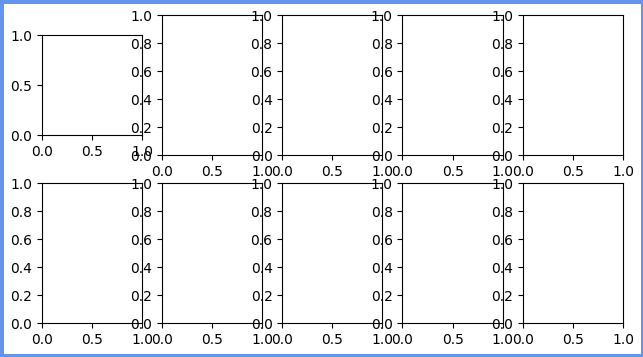

In [143]:
if n_tp > 0:
    file_prefix = path_dict['file_figure_prefix'] + "_"\
        + "ExampleImages_TruePostives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayImageConfusion(x_tra_tp,
                            y_true_tra_tp,
                            y_choice_tra_tp,
                            title_main="True Positives",
                            num=10,
                            file_prefix=file_prefix,
                            file_location=path_dict['dir_data_figures'],
                            file_suffix=path_dict['file_figure_suffix'])

if n_fp > 0:
    file_prefix = path_dict['file_figure_prefix'] + "_"\
        + "ExampleImages_FalsePostives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayImageConfusion(x_tra_fp,
                            y_true_tra_fp,
                            y_choice_tra_fp,
                            title_main="False Positives",
                            num=10,
                            file_prefix=file_prefix,
                            file_location=path_dict['dir_data_figures'],
                            file_suffix=path_dict['file_figure_suffix'])

if n_tn > 0:
    file_prefix = path_dict['file_figure_prefix'] + "_"\
        + "ExampleImages_TrueNegatives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayImageConfusion(x_tra_tn,
                            y_true_tra_tn,
                            y_choice_tra_tn,
                            title_main="True Negatives",
                            num=10,
                            file_prefix=file_prefix,
                            file_location=path_dict['dir_data_figures'],
                            file_suffix=path_dict['file_figure_suffix'])

if n_fn > 0:
    file_prefix = path_dict['file_figure_prefix'] + "_"\
        + "ExampleImages_FalseNegatives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayImageConfusion(x_tra_fn,
                            y_true_tra_fn,
                            y_choice_tra_fn,
                            title_main="False Negatives",
                            num=10,
                            file_prefix=file_prefix,
                            file_location=path_dict['dir_data_figures'],
                            file_suffix=path_dict['file_figure_suffix'])

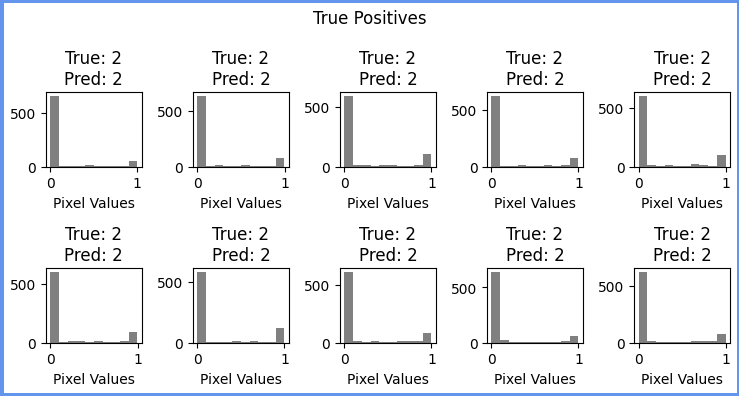

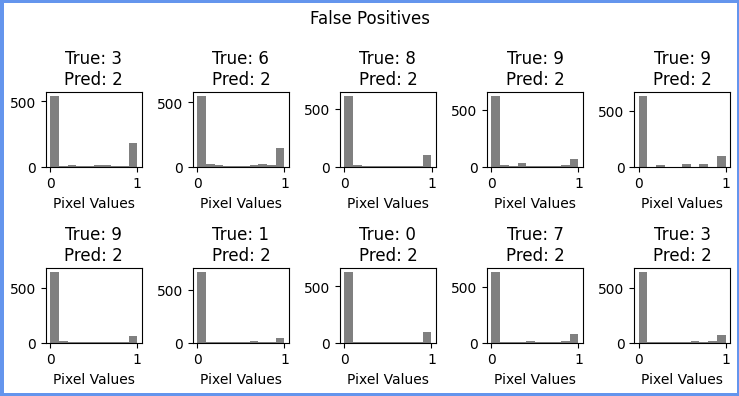

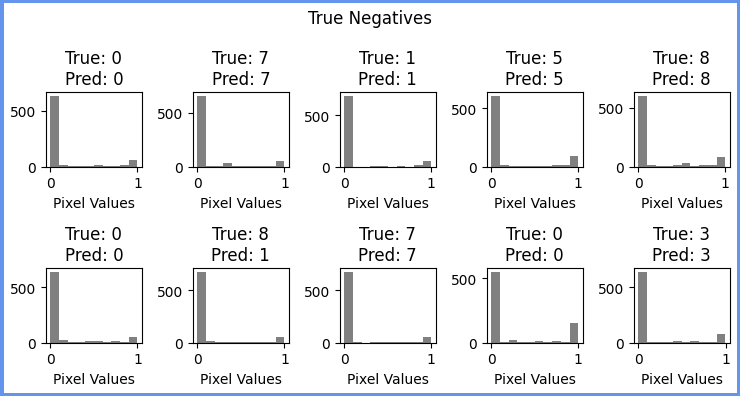

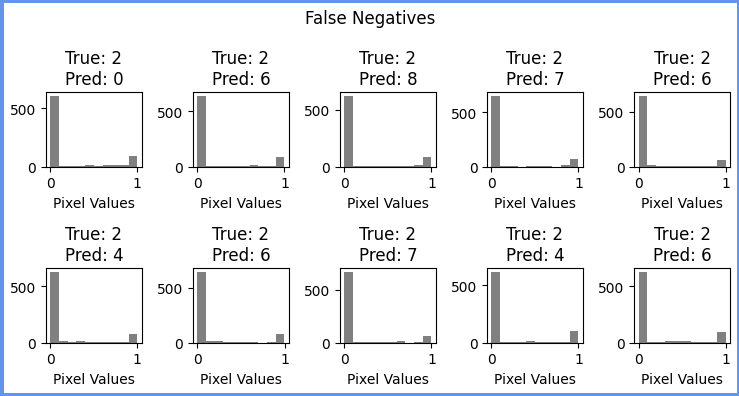

In [144]:
if n_tp > 0:
    file_prefix = path_dict['file_figure_prefix']\
        + "_" + "ExampleImages_TruePostives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayHistogramConfusion(x_tra_tp,
                                y_true_tra_tp,
                                y_choice_tra_tp,
                                title_main="True Positives",
                                num=10,
                                file_prefix=file_prefix,
                                file_location=path_dict['dir_data_figures'],
                                file_suffix=path_dict['file_figure_suffix'])

if n_fp > 0:
    file_prefix = path_dict['file_figure_prefix']\
        + "_" + "ExampleImages_FalsePostives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayHistogramConfusion(x_tra_fp,
                                y_true_tra_fp,
                                y_choice_tra_fp,
                                title_main="False Positives",
                                num=10,
                                file_prefix=file_prefix,
                                file_location=path_dict['dir_data_figures'],
                                file_suffix=path_dict['file_figure_suffix'])

if n_tn > 0:
    file_prefix = path_dict['file_figure_prefix']\
        + "_" + "ExampleImages_TrueNegatives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayHistogramConfusion(x_tra_tn,
                                y_true_tra_tn,
                                y_choice_tra_tn,
                                title_main="True Negatives",
                                num=10,
                                file_prefix=file_prefix,
                                file_location=path_dict['dir_data_figures'],
                                file_suffix=path_dict['file_figure_suffix'])

if n_fn > 0:
    file_prefix = path_dict['file_figure_prefix']\
        + "_" + "ExampleImages_FalseNegatives_on_class_"\
        + str(class_value) + "_" + path_dict['run_label']
    plotArrayHistogramConfusion(x_tra_fn,
                                y_true_tra_fn,
                                y_choice_tra_fn,
                                title_main="False Negatives",
                                num=10,
                                file_prefix=file_prefix,
                                file_location=path_dict['dir_data_figures'],
                                file_suffix=path_dict['file_figure_suffix'])

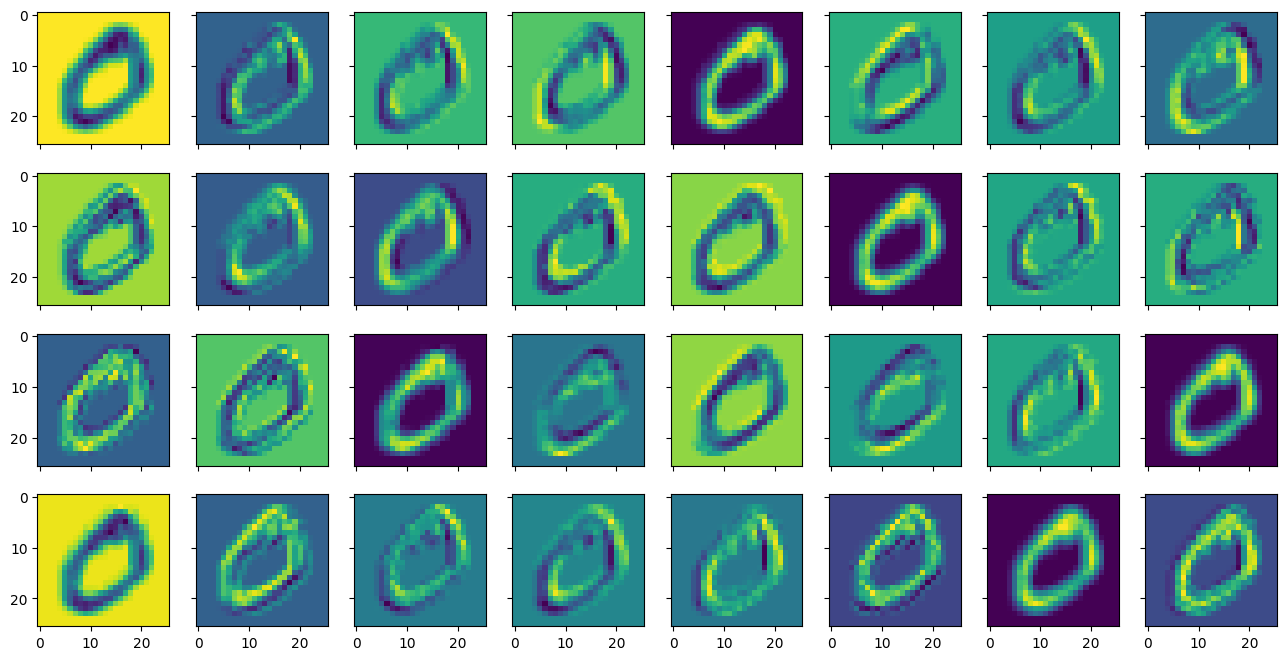

In [145]:
index_input_image = 1
number_conv_kernels = 32

input_image = dataset.data[index_input_image].type(torch.float32)
input_image = input_image.clone().detach()
input_image = input_image.unsqueeze(0)
input_image = input_image.to(device)

with torch.no_grad():
    feature_maps = model.conv1(input_image).cpu()

fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16, 8))

for i in range(0, number_conv_kernels):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[i])
